## Assignment: Image recognition
- Alumno 1: Alex Ferroni
- Alumno 2: Vittorio Alberto Gianfrate
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [121]:
!pip install rasterio

In [122]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [123]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [124]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [125]:
import warnings
import rasterio
import numpy as np
import os

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    
    # --- MODIFICA QUI ---
    # Il percorso su Kaggle. Se nello zip c'era una cartella 'xview_recognition', il percorso è questo:
    base_path = '/kaggle/input/recognition/xview_recognition/'
    
    # Se invece i file sono "sfusi" dentro recognition, usa solo: '/kaggle/input/recognition/'
    # Puoi verificare con: print(os.listdir('/kaggle/input/recognition/'))
    
    src_raster = rasterio.open(base_path + filename, 'r')
    # --------------------

    # RasterIO to OpenCV
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img /255.0

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [126]:
import json
import os

# Definiamo il percorso del file JSON
# Tentativo 1: Con sottocartella
json_file = '/kaggle/input/recognition/xview_recognition/xview_ann_train.json'

# Se non lo trova lì, prova nel percorso base (Tentativo 2)
if not os.path.exists(json_file):
    json_file = '/kaggle/input/recognition/xview_ann_train.json'

print(f"Caricamento annotazioni da: {json_file}")

with open(json_file) as ifs:
    json_data = json.load(ifs)
    
print("Annotazioni caricate con successo!")

Caricamento annotazioni da: /kaggle/input/recognition/xview_recognition/xview_ann_train.json
Annotazioni caricate con successo!


In [127]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [128]:
from sklearn.model_selection import train_test_split
labels_list = [x.objects[0].category for x in anns]
anns_train, anns_valid = train_test_split(anns, test_size=0.2, random_state=1, shuffle=True,stratify=labels_list)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 14996
Number of validation images: 3750


In [129]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

print('Load model')
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Dense(256))      
model.add(Activation('relu'))
model.add(Dense(64))      
model.add(Activation('relu'))
model.add(Dense(len(categories)))
model.add(Activation('softmax'))
model.summary()

Load model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 13)             │           845 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 13)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,552,717 (147.07 MB)

 Trainable params: 38,552,717 (147.07 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
from tensorflow.keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [131]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [132]:
def generator_images(objs, batch_size, do_shuffle=False,class_weights=None):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels,weights = [], [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
                if class_weights is not None:
                    weights.append(class_weights[obj.category])
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            if class_weights is not None:
                weights = np.array(weights).astype(np.float32)
                yield images, labels, weights # <--- Restituisce 3 cose!
            else:
                yield images, labels

In [133]:
from sklearn.utils import class_weight
import numpy as np

# compute the weights based on train data
train_labels = [ann.objects[0].category for ann in anns_train]
unique_classes = np.unique(train_labels)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels
)

# Dictionare for Keras
class_weights_dict = dict(zip(unique_classes, weights))

In [134]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True,class_weights=class_weights_dict)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [135]:
import math
import numpy as np

print('Training model')
epochs = 50
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.0914 - loss: 9.0962
Epoch 1: val_accuracy improved from -inf to 0.13200, saving model to model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 134s 141ms/step - accuracy: 0.0914 - loss: 9.0911 - val_accuracy: 0.1320 - val_loss: 2.3634 - learning_rate: 0.0010
Epoch 2/50
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1261 - loss: 2.5864
Epoch 2: val_accuracy improved from 0.13200 to 0.14400, saving model to model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 99s 106ms/step - accuracy: 0.1261 - loss: 2.5862 - val_accuracy: 0.1440 - val_loss: 2.2501 - learning_rate: 0.0010
Epoch 3/50
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1866 - loss: 2.2540
Epoch 3: val_accuracy improved from 0.14400 to 0.25867, saving model to model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - accuracy: 0.1866 - loss: 2.2539 - val_accuracy: 0.2587 - val_loss: 2.1542 - learning_rate: 0.0010
Epoch 4/50
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s

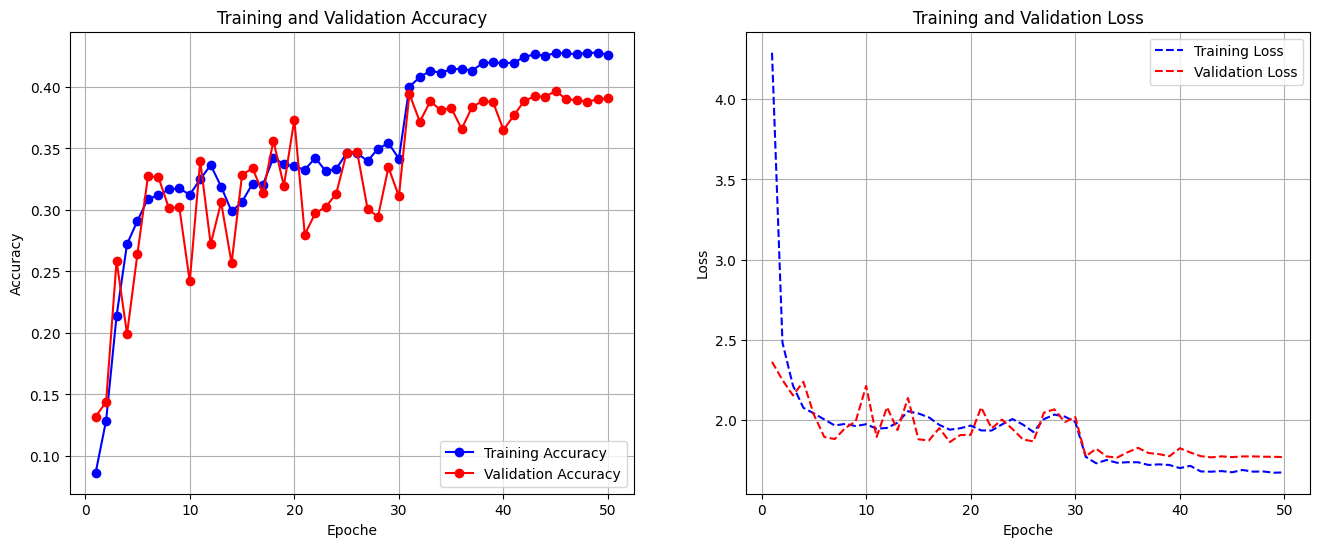

In [136]:
import matplotlib.pyplot as plt

def plot_results(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 6))

    # --- GRAFICO 1: ACCURACY
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoche')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # --- GRAFICO 2: LOSS 
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', linestyle='--')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()


plot_results(h)

#### Validation
Compute validation metrics.

In [137]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [138]:
import numpy as np

model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

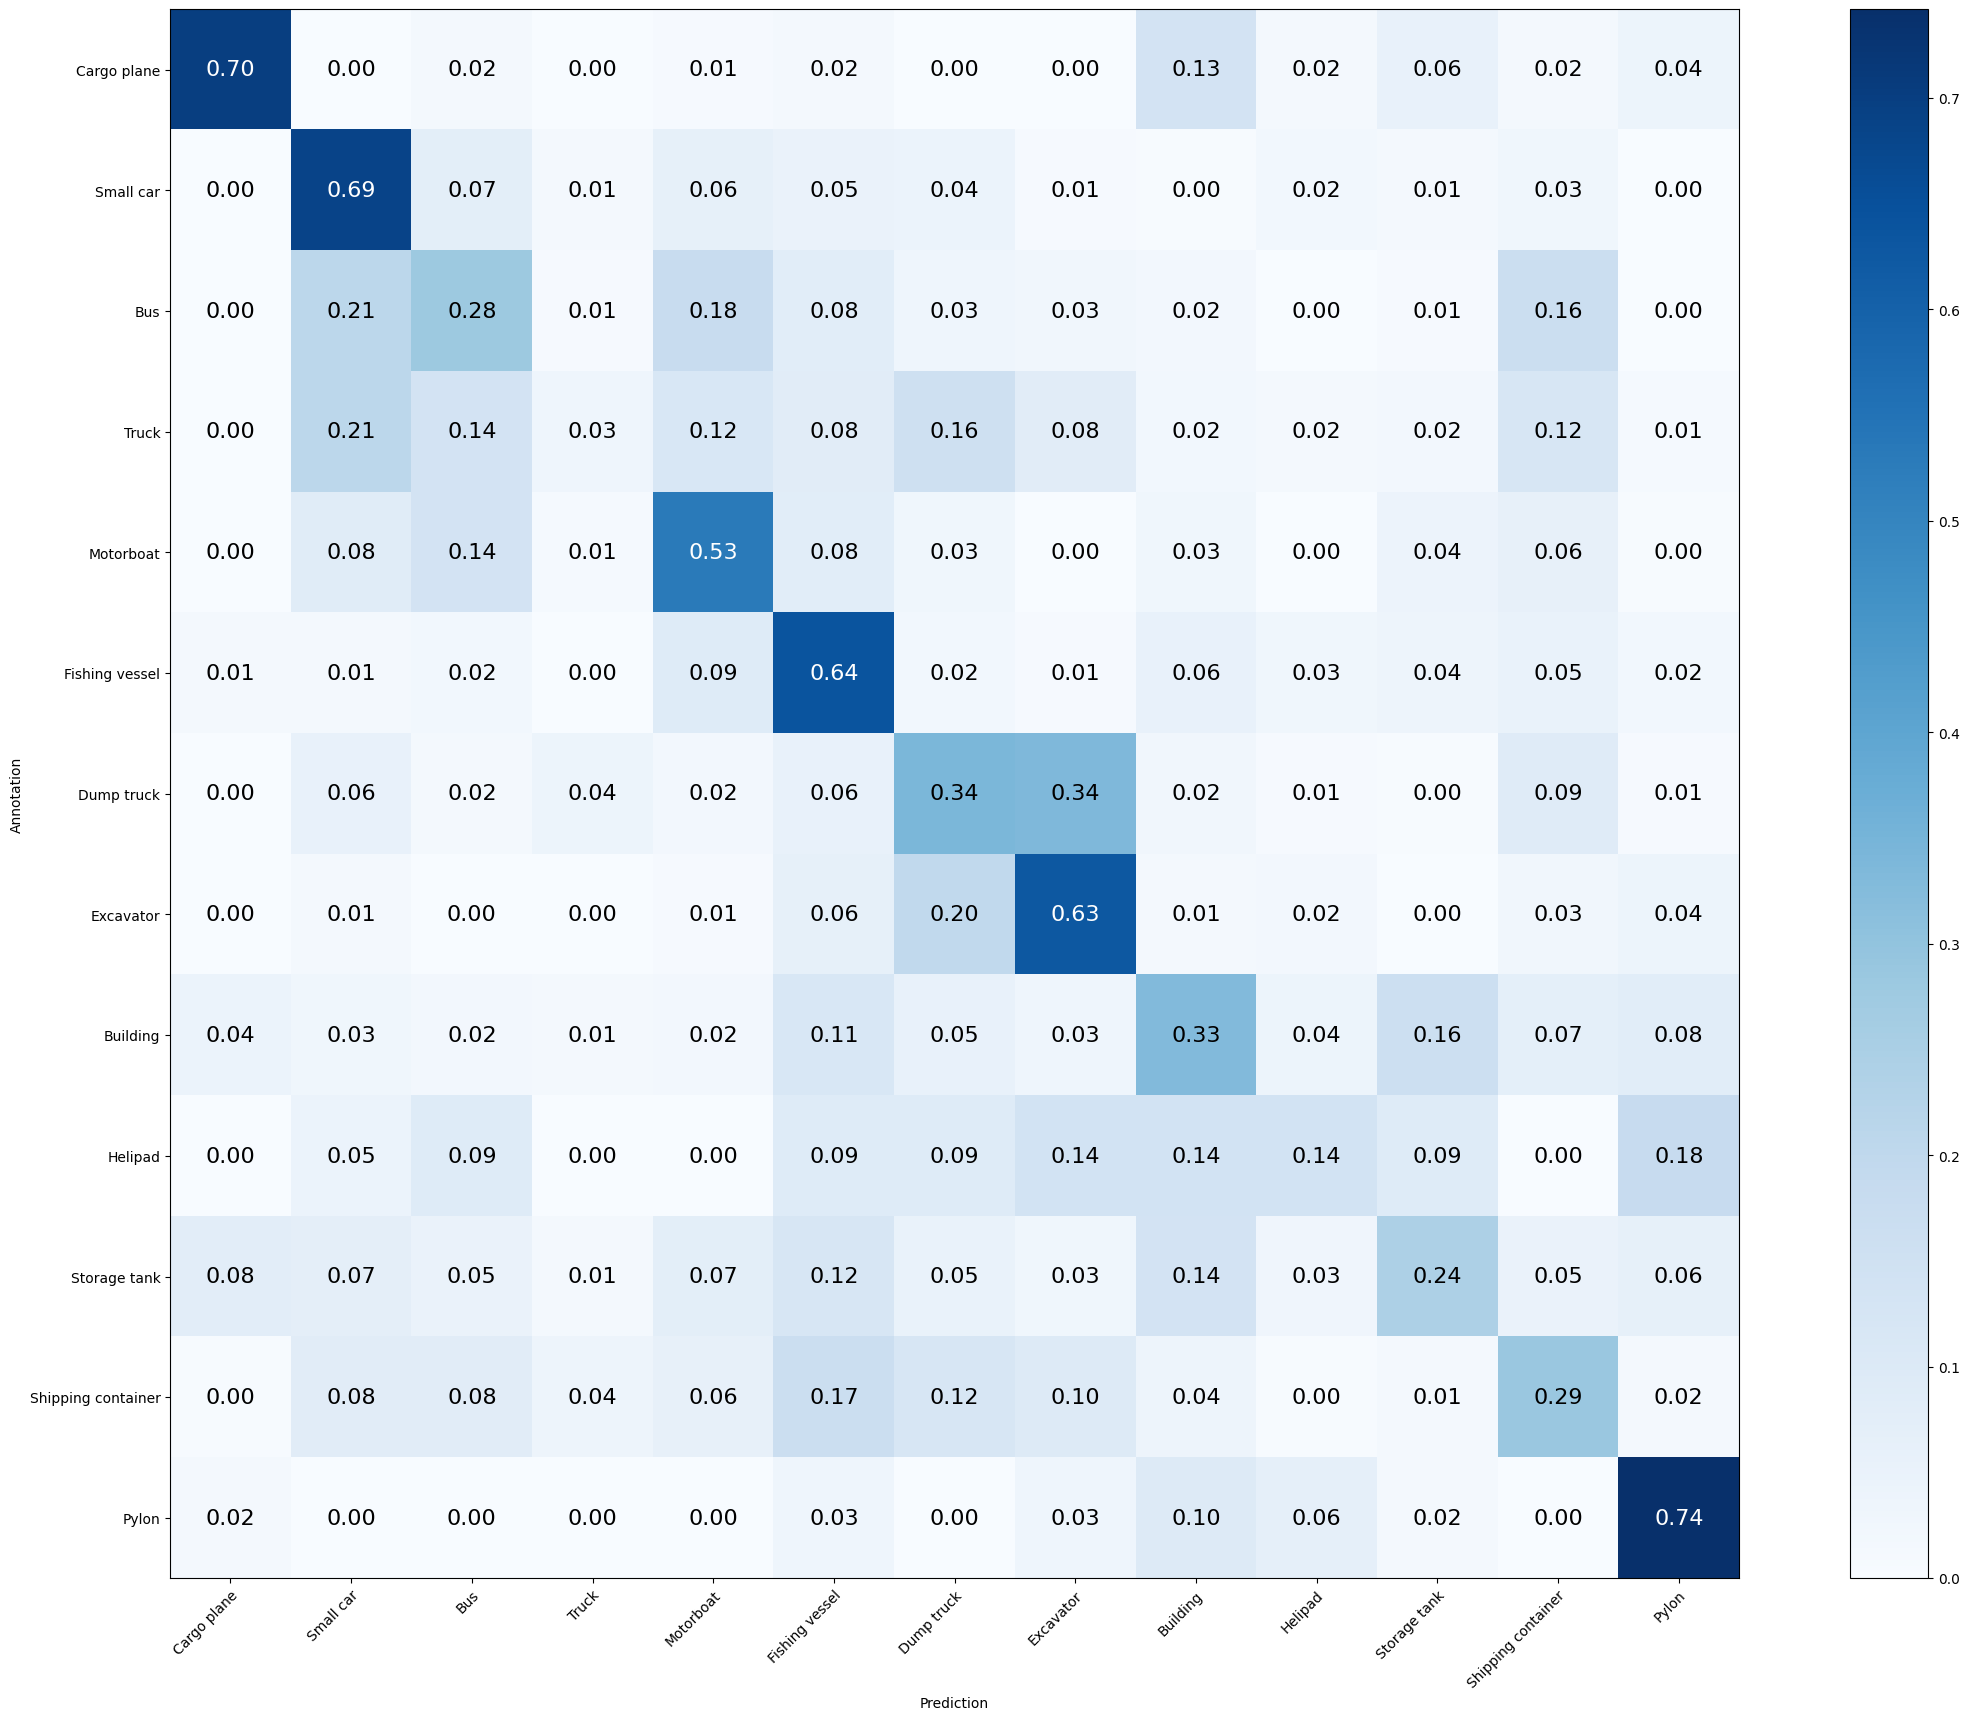

In [139]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [140]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 39.680%
Mean Recall: 42.818%
Mean Precision: 34.754%
> Cargo plane: Recall: 70.079% Precision: 60.135% Specificity: 98.372% Dice: 64.727%
> Small car: Recall: 68.571% Precision: 62.983% Specificity: 91.313% Dice: 65.659%
> Bus: Recall: 27.966% Precision: 33.000% Specificity: 94.081% Dice: 30.275%
> Truck: Recall: 3.394% Precision: 23.810% Specificity: 98.549% Dice: 5.941%
> Motorboat: Recall: 52.804% Precision: 33.041% Specificity: 93.524% Dice: 40.647%
> Fishing vessel: Recall: 63.830% Precision: 22.500% Specificity: 91.410% Dice: 33.272%
> Dump truck: Recall: 34.008% Precision: 25.767% Specificity: 93.092% Dice: 29.319%
> Excavator: Recall: 62.658% Precision: 33.000% Specificity: 94.404% Dice: 43.231%
> Building: Recall: 32.823% Precision: 66.667% Specificity: 96.107% Dice: 43.989%
> Helipad: Recall: 13.636% Precision: 3.846% Specificity: 97.988% Dice: 6.000%
> Storage tank: Recall: 24.150% Precision: 30.342% Specificity: 95.284% Dice: 26.894%
> Shipping container: Rec

#### Testing
Try to improve the results provided in the competition.

In [150]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/recognition/xview_recognition/xview_test'):
    for filename in filenames:
        relative_path = os.path.join('xview_test', filename)
        image = GenericImage(relative_path)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [ ]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [158]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)